# Interacciones entre personajes

Primero se importan todas las librerias necesarias.

In [1]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx
import matplotlib.pyplot as plt
import os

In [2]:
nlp = spacy.load("en_core_web_sm")

# Dataset - Personajes

En primer lugar, se carga el archivo de personajes creado previamente mediante Web Scraping para su uso posterior.

In [6]:
personajes_df = pd.read_csv('characters.csv', sep=';', encoding='utf-8', decimal=',')
personajes_df = personajes_df.drop(['Unnamed: 0'], axis=1)
personajes_df

,Characters
0,Rick
1,Morty
2,Robot Voice
3,Jerry
4,Summer
...,...
515,Business Man
516,Jerry
517,News Anchor
518,Beth


# Extracción de nombres

Utilizando la biblioteca Spacy, se procede a la apertura del archivo de texto creado previamente ('scripts.txt') con el fin de extraer las relaciones entre los personajes presentes en dicho archivo.

In [3]:
script_text = open('scripts.txt', 'r', encoding='utf-8').read()
script_doc = nlp(script_text)

In [4]:
displacy.render(script_doc[0:2000], style="ent", jupyter=True)

# Entidades por oración dentro del script 

Una vez que se tienen las entidades reconocidas, se crea un dataframe en el que se ha tokenizado cada oración dentro del archivo de scripts y las entidades que aparecen en esa oración.

In [7]:
sent_entity_df = []

# Loop through sentences, store named entity list for each sentence
for sent in script_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})
    
sent_entity_df = pd.DataFrame(sent_entity_df)

In [8]:
sent_entity_df

,sentence,entities
0,"(Rick, :, \n, stumbles, in, drunkenly, ,, and,...","[Rick, drunkenly]"
1,"(Morty, !)",[]
2,"(You, got, ta, \n , come, o...",[]
3,"(Jus, ', ...)",[Jus]
4,"(you, got, ta, come, with, me, ., \n)",[]
...,...,...
15484,"(I, ca, n't, believe, our, tax, dollars, pay, ...",[]
15485,"(Summer, :, , Jerry, ?)","[Summer, Jerry]"
15486,"(J, -, Jerry, Smith, ?, \n, Morty, :, , Beth,...","[J-Jerry Smith, Beth Sanchez]"
15487,"(I, hate, acting, ,, I, hate, cocaine, ,, I, h...",[Kristen Stewart]


A continuación, se aplica un filtro a estas entidades para extraer únicamente los nombres de los personajes

In [9]:
# Function to filter out non-character entities
def filter_entity(ent_list, personajes_df):
    return [ent for ent in ent_list 
            if ent in list(personajes_df.Characters)]

In [10]:
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, personajes_df))

# Filter out sentences that don't have any character entities
sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
sent_entity_df_filtered.head(10)

,sentence,entities,character_entities
0,"(Rick, :, \n, stumbles, in, drunkenly, ,, and,...","[Rick, drunkenly]",[Rick]
6,"(What, ,, Rick, ?)",[Rick],[Rick]
8,"(Rick, :, , I, got, a, surprise, for, you, ,,...",[Rick],[Rick]
12,"(Rick, :, \n, spills, alcohol, on, Morty, 's, ...","[Rick, Morty]","[Rick, Morty]"
19,"(Rick, :, , We, got, ta, go, ,, got, ta, get,...",[Rick],[Rick]
20,"(Got, a, surprise, for, you, Morty, ., \n)",[Morty],[Morty]
21,"(Rick, :, \n, Rick, drives, through, the, nigh...","[Rick, Rick, the night]","[Rick, Rick]"
22,"(What, do, you, think, of, this, ..., \n ...",[Morty],[Morty]
25,"(Yeah, ,, Rick, ...)",[Rick],[Rick]
27,"(Is, this, the, surprise, ?, \n, Rick, :, , M...",[Rick],[Rick]


Se explora un poco el dataset con la información filtrada.

In [11]:
sent_entity_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4852 entries, 0 to 15485
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   sentence            4852 non-null   object
 1   entities            4852 non-null   object
 2   character_entities  4852 non-null   object
dtypes: object(3)
memory usage: 151.6+ KB


In [12]:
sent_entity_df_filtered['character_entities'].value_counts()

character_entities
[Rick]                  1501
[Jerry]                  628
[Summer]                 434
[Beth]                   386
[Morty]                  275
                        ... 
[Summers 2 & 3]            1
[Morty 1 & 4]              1
[Morty 1]                  1
[Rick 1, Rick 4]           1
[Beth, Jerry, Morty]       1
Name: count, Length: 438, dtype: int64

In [13]:
sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0] 
                                                                                                               for item in x])


C:\Users\arace\AppData\Local\Temp\ipykernel_5552\2595230222.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]


In [14]:
pd.reset_option('^display.', silent=True)
sent_entity_df_filtered

,sentence,entities,character_entities
0,"(Rick, :, \n, stumbles, in, drunkenly, ,, and,...","[Rick, drunkenly]",[Rick]
6,"(What, ,, Rick, ?)",[Rick],[Rick]
8,"(Rick, :, , I, got, a, surprise, for, you, ,,...",[Rick],[Rick]
12,"(Rick, :, \n, spills, alcohol, on, Morty, 's, ...","[Rick, Morty]","[Rick, Morty]"
19,"(Rick, :, , We, got, ta, go, ,, got, ta, get,...",[Rick],[Rick]
...,...,...,...
15478,"(Jerry, :, , Come, on, ,, Je-, Are, you, kidd...","[Jerry, Jerry]","[Jerry, Jerry]"
15480,"(Rick, :, )",[Rick],[Rick]
15482,"(Beth, (, on, Device, ), :, \n, Jerry, (, on,...","[Beth, Jerry]","[Beth, Jerry]"
15483,"(Rick, :, , they, 've, got, a, clear, shot, ...",[Rick],[Rick]


# Estableciendo interacciones

Una vez identificados los personajes, se crea una ventana de cinco líneas para establecer relaciones entre los nombres que aparezcan dentro de ese intervalo para después crear un dataframe.

In [15]:
window_size = 5
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])
    
    # Remove duplicated characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list)) 
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})

In [16]:
relationship_df = pd.DataFrame(relationships)
relationship_df

,source,target
0,Rick,Morty
1,Rick,Morty
2,Rick,Morty
3,Rick,Morty
4,Rick,Morty
...,...,...
15604,Rick,Summer
15605,Summer,Jerry
15606,Rick,Summer
15607,Summer,Jerry


# Valores

Después de haber establecido las relaciones entre los personajes, se asigna un valor de uno a cada relación, y luego se realiza la suma para determinar el número total de interacciones.

In [17]:
relationship_df["value"] = 1
relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()

In [18]:
relationship_df.head(10).sort_values(by='value', ascending=False)

,source,target,value
0,Rick,Morty,1201
1,Morty,Rick,792
9,Summer,Jerry,375
6,Jerry,Summer,333
8,Beth,Summer,274
7,Summer,Beth,243
3,Jessica,Rick,56
4,Rick,Jessica,47
5,Jessica,Morty,33
2,Morty,Jessica,32


Luego, se guarda el DataFrame como un archivo CSV para su uso futuro y se procede a explorar el contenido del DataFrame.

In [19]:
relationship_df.to_csv('interacciones.csv', sep=';', index=True, encoding='utf-8', decimal=',')

In [21]:
relationship_df[relationship_df['target'] == 'Morty']

,source,target,value
0,Rick,Morty,1201
5,Jessica,Morty,33
18,Goldenfold,Morty,28
23,Frank,Morty,8
38,Beth,Morty,61
42,Principal,Morty,15
51,Jerry,Morty,61
61,Summer,Morty,59
72,Ruben,Morty,11
89,Annie,Morty,13


In [22]:
relationship_df[relationship_df['source'] == 'Morty']

,source,target,value
1,Morty,Rick,792
2,Morty,Jessica,32
20,Morty,Goldenfold,30
24,Morty,Frank,9
27,Morty,Summer,89
39,Morty,Jerry,112
40,Morty,Principal,14
43,Morty,Beth,41
62,Morty,Jacob,5
74,Morty,Ruben,6


# Graph Analysis and visualization

Utilizando la biblioteca NetworkX, creamos un grafo que representa las conexiones entre nodos en forma de una lista de aristas (edges). A continuación, aplicamos el algoritmo de Kamada-Kawai para visualizar de manera efectiva las relaciones entre los personajes.

In [23]:
G = nx.from_pandas_edgelist(relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

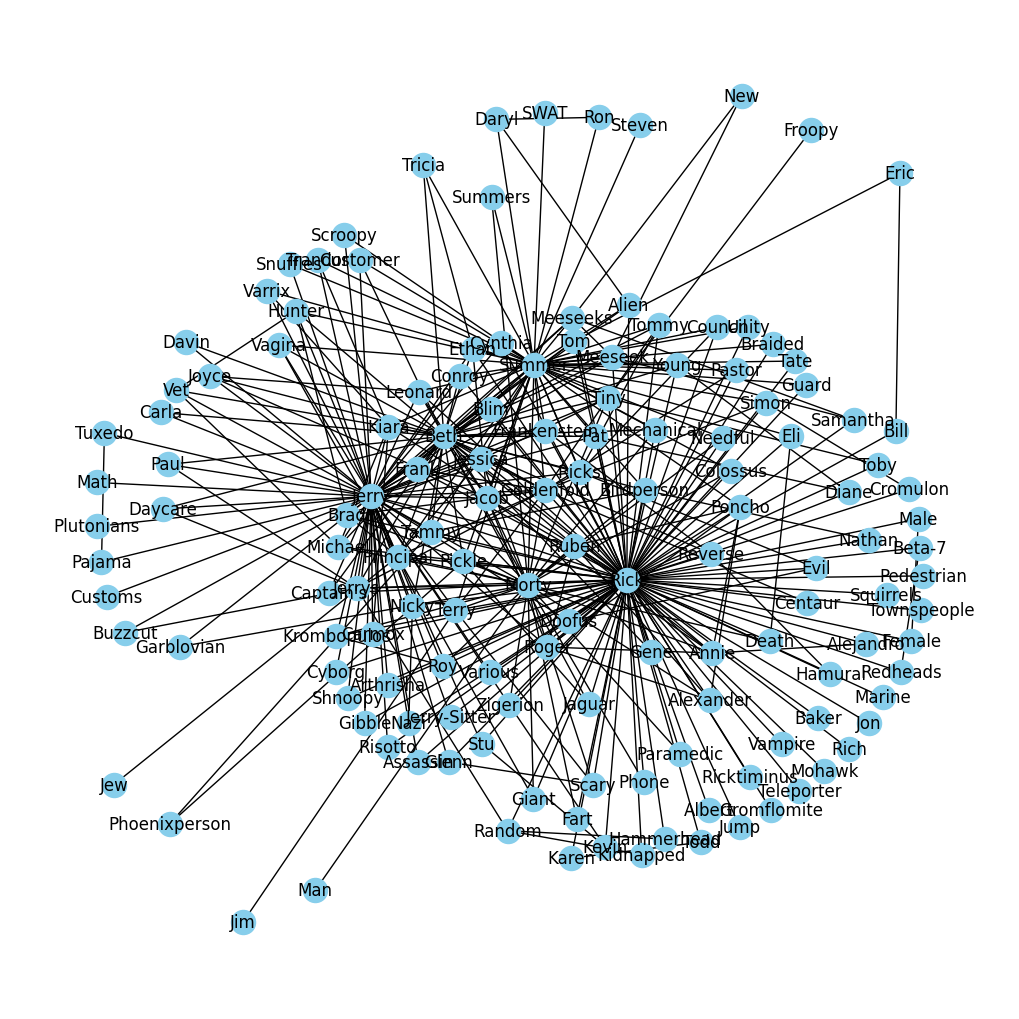

In [24]:
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

# FIN